## **Problem Statement**



The problem is to develop a sales model that can accurately predict the future sales of each product at BigMart stores. The model should take into account the various attributes of both the products and the stores to identify the key factors that contribute to increased sales.

## **Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [2]:
df1=pd.read_csv("/content/Train.csv")

In [3]:
df2=pd.read_csv("/content/Test.csv")

In [4]:
df1.shape

(8523, 12)

In [5]:
df2.shape

(5681, 11)

In [6]:
df1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Here will be handling of mistyping or non suitable data

In [8]:
print(df1['Item_Fat_Content'].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


In [9]:
df1['Item_Fat_Content'] = df2['Item_Fat_Content'].str.replace('low fat', 'Low Fat')
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].str.replace('low fat', 'Low Fat')

In [10]:
df1['Item_Fat_Content'] = df1['Item_Fat_Content'].str.replace('LF', 'Low Fat')
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].str.replace('LF', 'Low Fat')

In [11]:
df1['Item_Fat_Content'] = df1['Item_Fat_Content'].str.replace('reg', 'Regular')
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].str.replace('reg', 'Regular')

In [12]:
print(df1['Item_Fat_Content'].unique())
print(df2['Item_Fat_Content'].unique())

['Low Fat' 'Regular' nan]
['Low Fat' 'Regular']


Columns " Item_Identifier " and " Outlet_Identifier " will not help in the model so we can drop them

In [13]:
df1.drop("Item_Identifier",axis=1,inplace=True)
df1.drop("Outlet_Identifier",axis=1,inplace=True)
df2.drop("Item_Identifier",axis=1,inplace=True)
df2.drop("Outlet_Identifier",axis=1,inplace=True)

### **Handling Nulls**

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           5681 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                4705 non-null   float64
 1   Item_Fat_Content           5681 non-null   object 
 2   Item_Visibility            5681 non-null   float64
 3   Item_Type                  5681 non-null   object 
 4   Item_MRP                   5681 non-null   float64
 5   Outlet_Establishment_Year  5681 non-null   int64  
 6   Outlet_Size                4075 non-null   object 
 7   Outlet_Location_Type       5681 non-null   object 
 8   Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 399.6+ KB


In [16]:
df1.isnull().sum()

Item_Weight                  1463
Item_Fat_Content             2842
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [17]:
df2.isnull().sum()

Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [18]:
null1=df1.isna().sum()
print("Item Weight:",(null1[0]/8523*100),"%")
print("Item Fat Content :",(null1[1]/8523*100),"%")
print("Outlet Size:",(null1[6]/8523*100),"%")

Item Weight: 17.165317376510618 %
Item Fat Content : 33.345066291212014 %
Outlet Size: 28.27642848762173 %


In [19]:
null2=df2.isna().sum()
print("Item Weight:",(null1[0]/5681*100),"%")
print("Outlet Size:",(null1[6]/5681*100),"%")

Item Weight: 25.75250836120401 %
Outlet Size: 42.42210878366485 %


Null percentage is not huge and not small so solution is replacing categorical data with mode and Replacing numerical data with mean or median depending on skewness

In [20]:
df1['Item_Fat_Content'].replace(np.nan, df1['Item_Fat_Content'].mode()[0], inplace=True)

In [21]:
df1['Outlet_Size'].replace(np.nan, df1['Outlet_Size'].mode()[0], inplace=True)

In [22]:
df2['Outlet_Size'].replace(np.nan, df2['Outlet_Size'].mode()[0], inplace=True)

<ipython-input-23-7c9ac52cb0d9>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['Item_Weight'])


<Axes: xlabel='Item_Weight', ylabel='Density'>

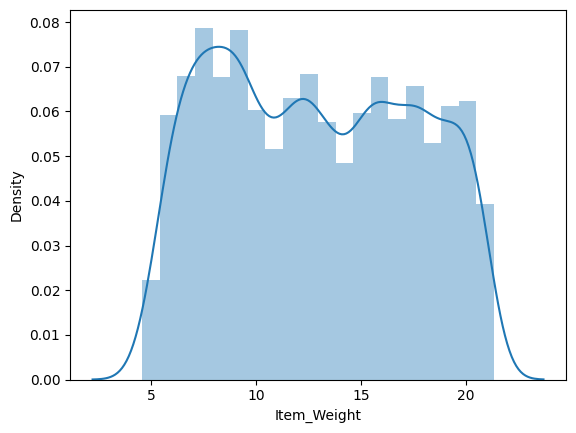

In [23]:
sns.distplot(df1['Item_Weight'])

<ipython-input-24-63e5102ab84f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2['Item_Weight'])


<Axes: xlabel='Item_Weight', ylabel='Density'>

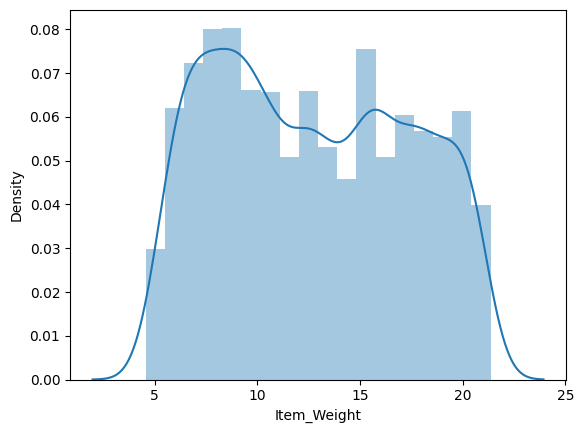

In [24]:
sns.distplot(df2['Item_Weight'])

In [25]:
print(df1['Item_Weight'].skew())
print(df2['Item_Weight'].skew())

0.0824262091221237
0.12997502891537796


Column " Item Weight " is  almost symmetrical so we'll replace with mean

In [26]:
df1['Item_Weight'].replace(np.nan, df1['Item_Weight'].mean(), inplace=True)
df2['Item_Weight'].replace(np.nan, df2['Item_Weight'].mean(), inplace=True)

In [27]:
df1.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [28]:
df2.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

So , Handling nulls is done

### **Handling Skewness**

In [29]:
print(df1.skew())

Item_Weight                  0.090561
Item_Visibility              1.167091
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
Item_Outlet_Sales            1.177531
dtype: float64


<ipython-input-29-b2ba07c17d97>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df1.skew())


In [30]:
print(df2.skew())

Item_Weight                  0.142813
Item_Visibility              1.238312
Item_MRP                     0.136182
Outlet_Establishment_Year   -0.396306
dtype: float64


<ipython-input-30-ca0f7b4021e7>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df2.skew())


<Axes: xlabel='Item_Visibility', ylabel='Count'>

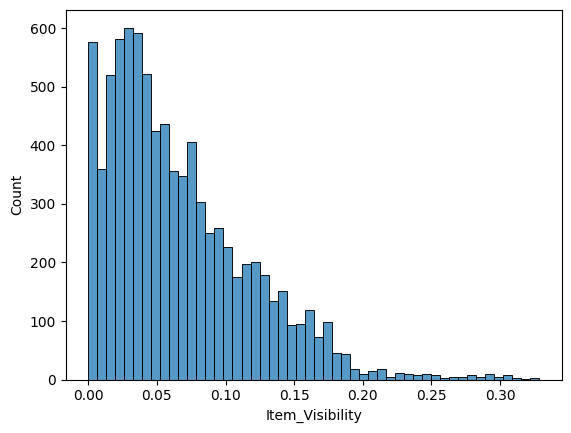

In [31]:
sns.histplot(df1['Item_Visibility'])

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

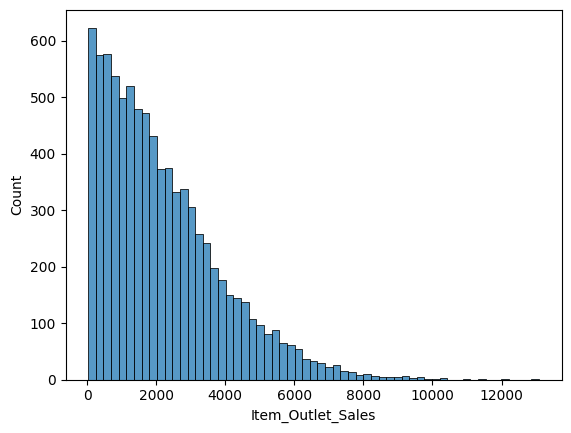

In [32]:
sns.histplot(df1['Item_Outlet_Sales'])

<Axes: xlabel='Item_Visibility', ylabel='Count'>

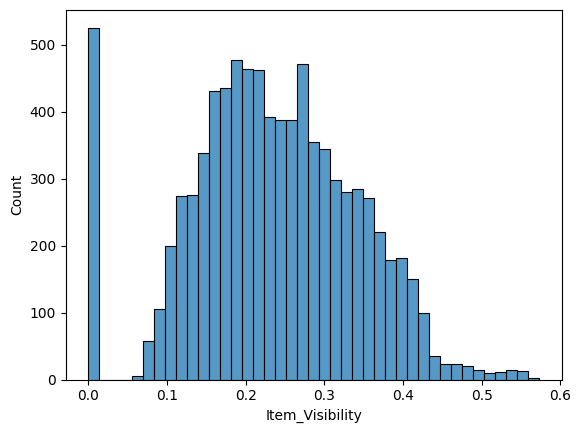

In [33]:
df1['Item_Visibility'] = np.sqrt(df1['Item_Visibility'])
sns.histplot(df1['Item_Visibility'])

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

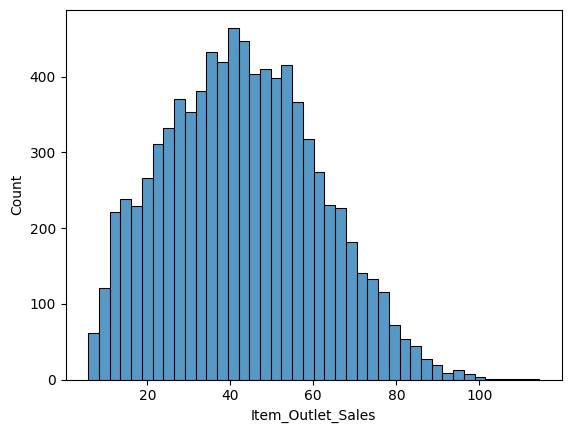

In [34]:
df1['Item_Outlet_Sales'] = np.sqrt(df1['Item_Outlet_Sales'])
sns.histplot(df1['Item_Outlet_Sales'])

<Axes: xlabel='Item_Visibility', ylabel='Count'>

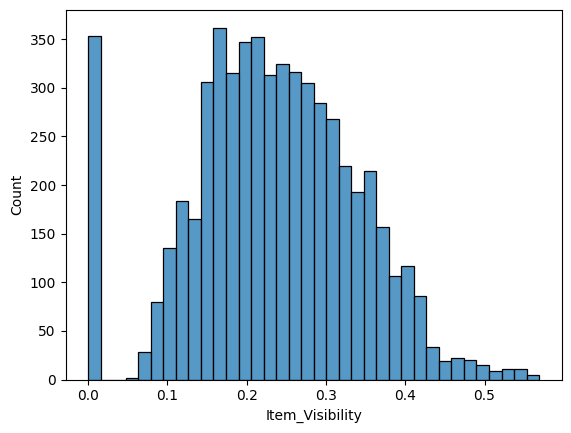

In [35]:
df2['Item_Visibility'] = np.sqrt(df2['Item_Visibility'])
sns.histplot(df2['Item_Visibility'])

The distribution is better than before

### **Handling Outliers**

<Axes: >

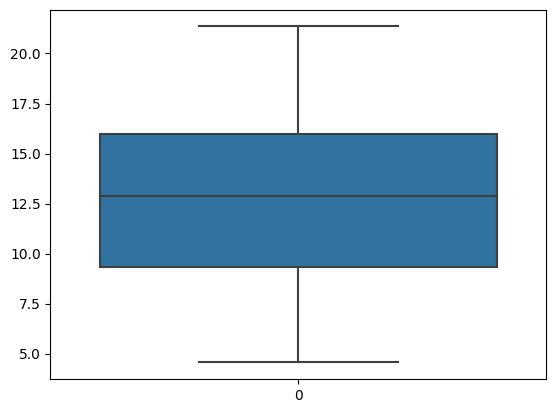

In [36]:
sns.boxplot(df1['Item_Weight'])

<Axes: >

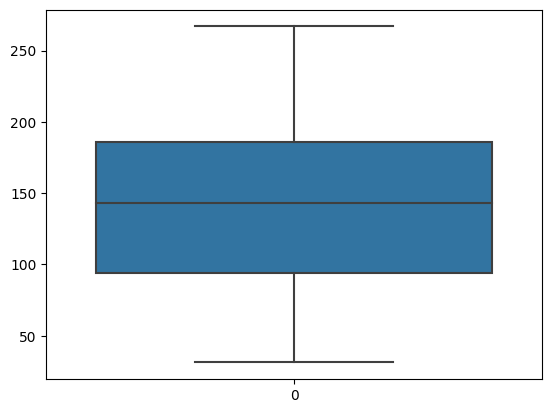

In [37]:
sns.boxplot(df1['Item_MRP'])

<Axes: >

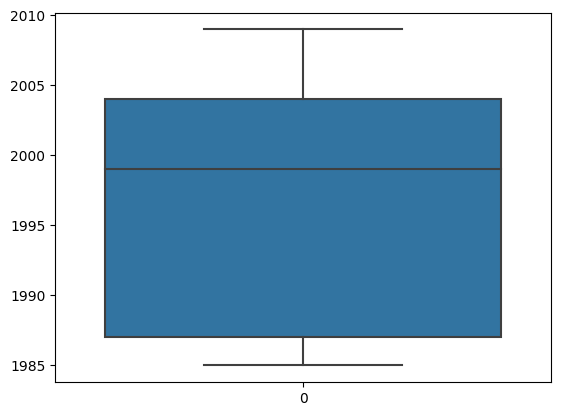

In [38]:
sns.boxplot(df1['Outlet_Establishment_Year'])

<Axes: >

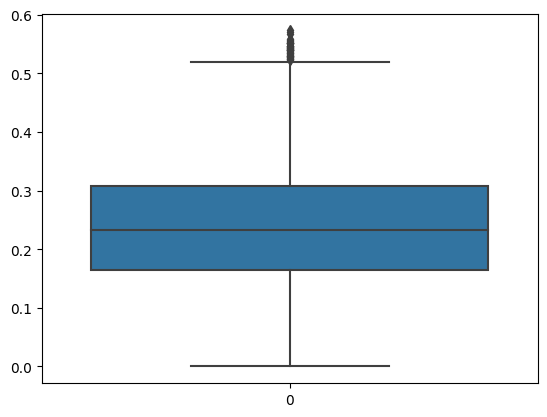

In [39]:
sns.boxplot(df1['Item_Visibility'])

In [40]:
maximum_value = df1['Item_Visibility'].max()
print("Maximum value of Item Visibility:", maximum_value)

Maximum value of Item Visibility: 0.5730540532968945


In [41]:
Q1 = df1['Item_Visibility'].quantile(0.25)
Q3 = df1['Item_Visibility'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df1[(df1['Item_Visibility'] < lower_bound) | (df1['Item_Visibility'] > upper_bound)]
mean_value = df1['Item_Visibility'].median()

df1.loc[outliers.index, 'Item_Visibility'] = mean_value


<Axes: >

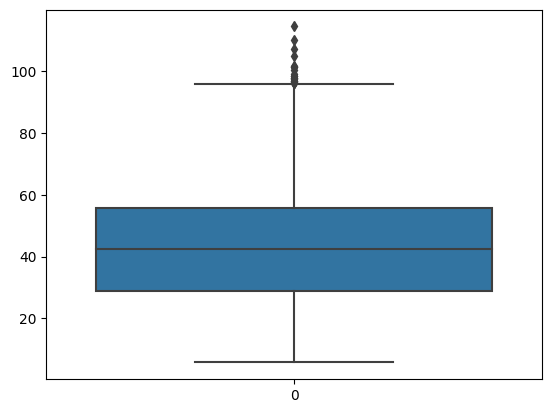

In [42]:
sns.boxplot(df1['Item_Outlet_Sales'])

In [43]:
maximum_value = df1['Item_Outlet_Sales'].max()
print("Maximum value of Item Outlet Sales:", maximum_value)

Maximum value of Item Outlet Sales: 114.39827271423289


Here we see that the outliers in column " Item Outlet Sales" are normal and make sense so we'll leave them

In [44]:
df3=df1

### **Handling Categorical Data**

In [45]:
print(df1['Item_Fat_Content'].unique())

['Low Fat' 'Regular']


Column " Item Fat Content " has only 2 values so using one hot encoding is better

In [46]:
df1 = pd.get_dummies(df1, columns=['Item_Fat_Content'])
df2 = pd.get_dummies(df2, columns=['Item_Fat_Content'])

-----------------------------------------------------------------

In [47]:
print(df1['Item_Type'].unique())

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


Column " Item Type " has many values so using Label Encoding is better

In [48]:
label_encoder = LabelEncoder()
df1['Item_Type_Encoded'] = label_encoder.fit_transform(df1['Item_Type'])
df1.drop("Item_Type",axis=1,inplace=True)

In [49]:
df2['Item_Type_Encoded'] = label_encoder.fit_transform(df2['Item_Type'])
df2.drop("Item_Type",axis=1,inplace=True)

-----------------------------------------------------------------------------

In [50]:
print(df1['Outlet_Size'].unique())

['Medium' 'High' 'Small']


Column " Outlet Size " has an order data so we will use Ordinal Encoding

In [51]:
size= {'Small': 0, 'Medium': 1, 'High': 2}
df1['Outlet_Size_Encoded'] = df1['Outlet_Size'].replace(size)
df1.drop("Outlet_Size",axis=1,inplace=True)

In [52]:
size2= {'Small': 0, 'Medium': 1, 'High': 2}
df2['Outlet_Size_Encoded'] = df2['Outlet_Size'].replace(size2)
df2.drop("Outlet_Size",axis=1,inplace=True)

-------------------------------------------------------------------------------

In [53]:
print(df1['Outlet_Location_Type'].unique())

['Tier 1' 'Tier 3' 'Tier 2']


In [54]:
df1['Outlet_Location_Type_Encoded'] = label_encoder.fit_transform(df1['Outlet_Location_Type'])
df1.drop("Outlet_Location_Type",axis=1,inplace=True)

In [55]:
df2['Outlet_Location_Type_Encoded'] = label_encoder.fit_transform(df2['Outlet_Location_Type'])
df2.drop("Outlet_Location_Type",axis=1,inplace=True)

---------------------------------------------------------------------------

In [56]:
print(df1['Outlet_Type'].unique())

['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [57]:
df1['Outlet_Type_Encoded'] = label_encoder.fit_transform(df1['Outlet_Type'])
df1.drop("Outlet_Type",axis=1,inplace=True)

In [58]:
df2['Outlet_Type_Encoded'] = label_encoder.fit_transform(df2['Outlet_Type'])
df2.drop("Outlet_Type",axis=1,inplace=True)

----------------------------------------------------------------------

In [59]:
df1

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Encoded,Outlet_Size_Encoded,Outlet_Location_Type_Encoded,Outlet_Type_Encoded
0,9.300,0.126678,249.8092,1999,61.115775,1,0,4,1,0,1
1,5.920,0.138846,48.2692,2009,21.057607,0,1,14,1,2,2
2,17.500,0.129461,141.6180,1999,45.795961,1,0,10,1,0,1
3,19.200,0.000000,182.0950,1998,27.062520,1,0,6,1,2,0
4,8.930,0.000000,53.8614,1987,31.538947,0,1,9,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.238293,214.5218,1987,52.710373,1,0,13,2,2,1
8519,8.380,0.216754,108.1570,2002,23.436830,1,0,0,1,1,1
8520,10.600,0.187580,85.1224,2004,34.541477,1,0,8,0,1,1
8521,7.210,0.381078,103.1332,2009,42.960419,1,0,13,1,2,2


In [60]:
df2

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Encoded,Outlet_Size_Encoded,Outlet_Location_Type_Encoded,Outlet_Type_Encoded
0,20.750000,0.086976,107.8622,1999,1,0,13,1,0,1
1,8.300000,0.196030,87.3198,2007,0,1,4,1,1,1
2,14.600000,0.315555,241.7538,1998,1,0,11,1,2,0
3,7.315000,0.124050,155.0340,2007,1,0,13,1,1,1
4,12.695633,0.344383,234.2300,1985,0,1,4,1,2,3
...,...,...,...,...,...,...,...,...,...,...
5676,10.500000,0.116174,141.3154,1997,0,1,13,0,0,1
5677,7.600000,0.378141,169.1448,2009,0,1,15,1,2,2
5678,10.000000,0.271162,118.7440,2002,1,0,8,1,1,1
5679,15.300000,0.000000,214.6218,2007,0,1,3,1,1,1


Encoding is done

### **Scaling**

In [61]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df1)

df1 = pd.DataFrame(scaled_data, columns=df1.columns)

In [62]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df2)

df2 = pd.DataFrame(scaled_data, columns=df2.columns)

## **Analysis**

**Distribution of Fats in Items**

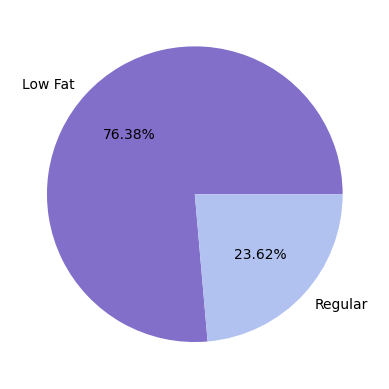

In [63]:
label = ["Low Fat", "Regular"]
colors = ["#826fc9", "#b1c2f0"]

plt.pie(df3["Item_Fat_Content"].value_counts(), labels=label, autopct='%2.2f%%', colors=colors)
plt.show()

**Item Types Distribution in data**

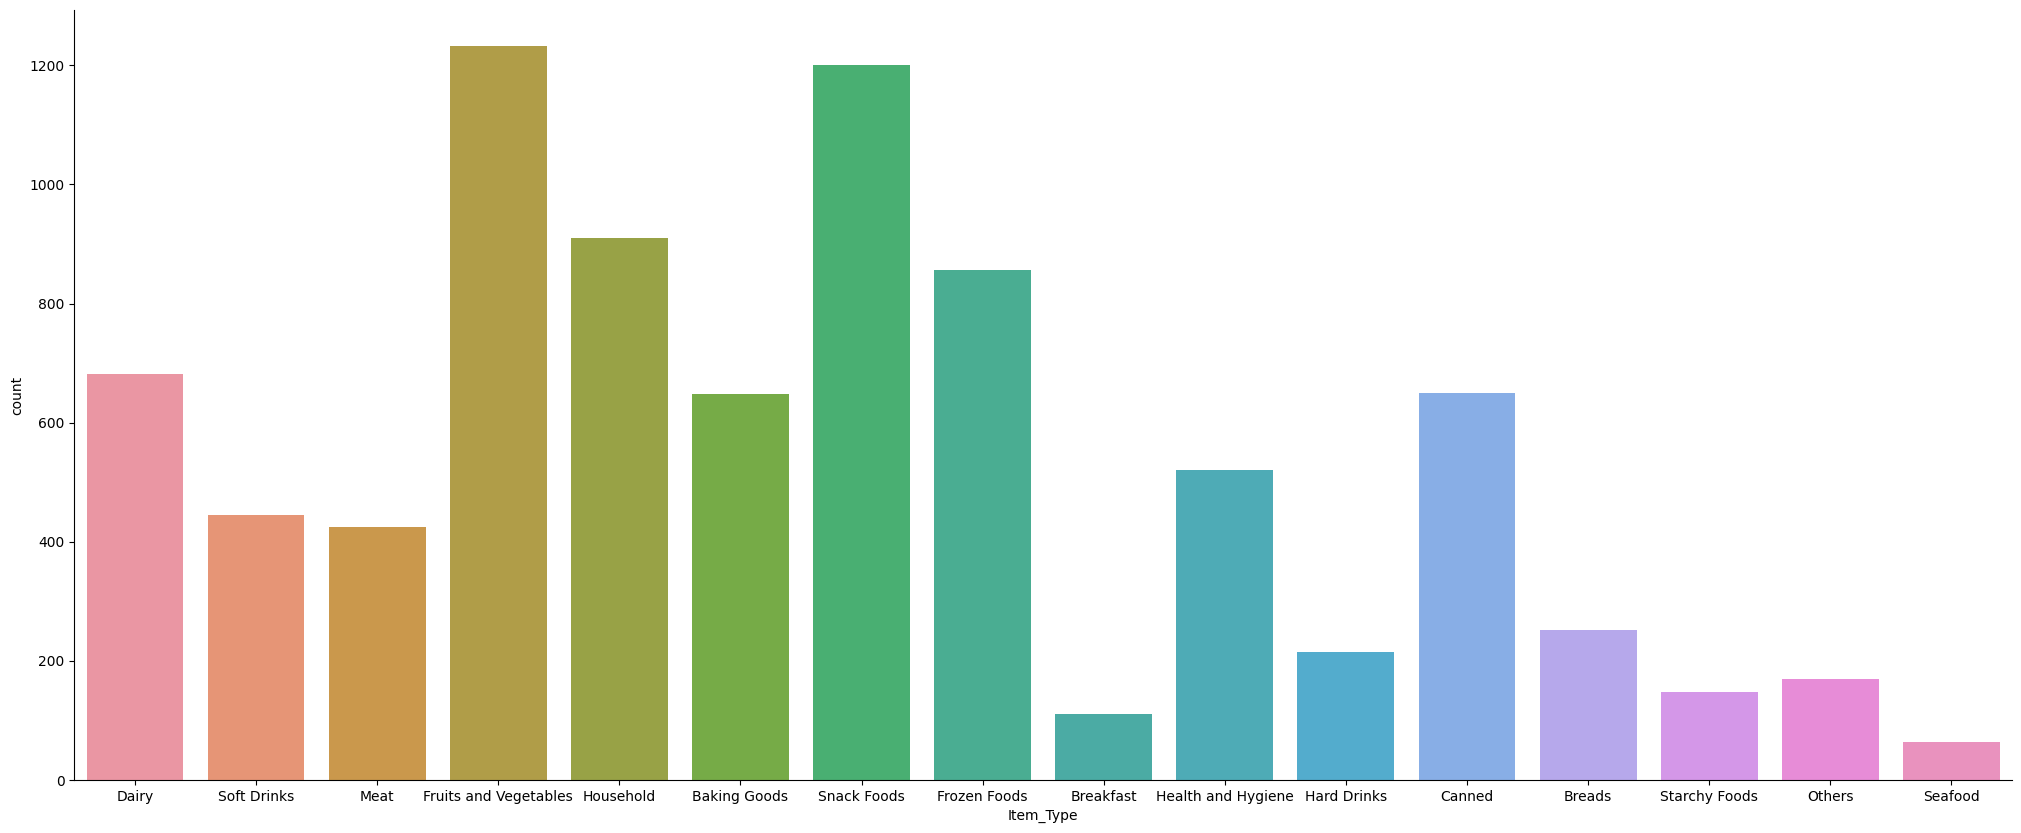

In [64]:
plt.figure(figsize=(25,10))
sns.countplot(x="Item_Type", data=df3)
sns.despine()

<ipython-input-65-44eda832a4d9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df3.corr()


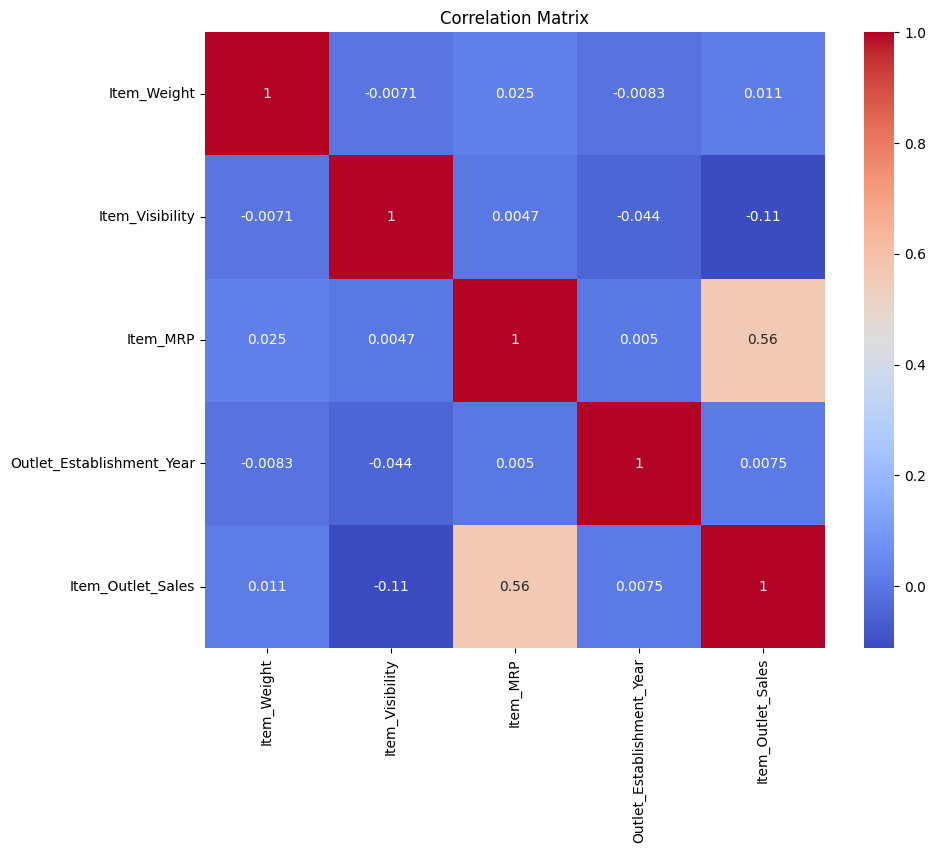

In [65]:
plt.figure(figsize=(10, 8))
correlation = df3.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


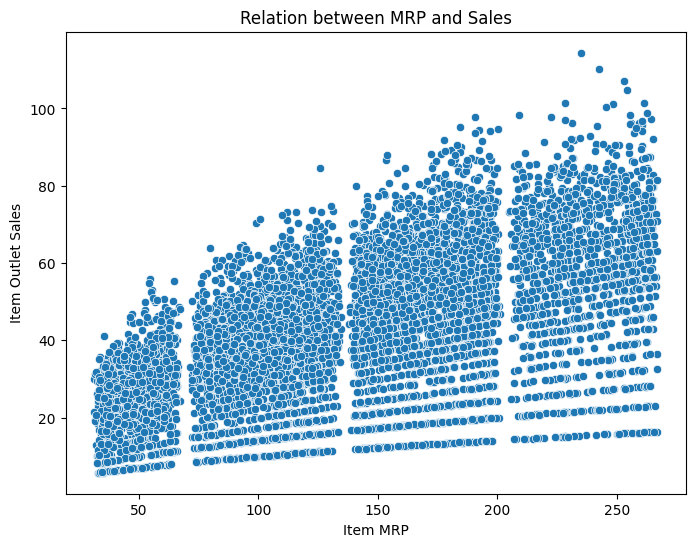

In [66]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=df3)
plt.title('Relation between MRP and Sales')
plt.xlabel('Item MRP')
plt.ylabel('Item Outlet Sales')
plt.show()

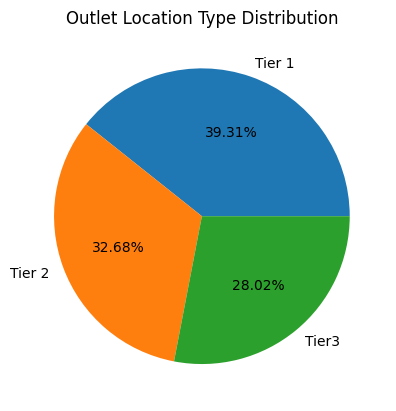

In [67]:
label = ["Tier 1", "Tier 2" , "Tier3"]

plt.pie(df3["Outlet_Location_Type"].value_counts(), labels=label, autopct='%2.2f%%')
plt.title('Outlet Location Type Distribution')
plt.show()

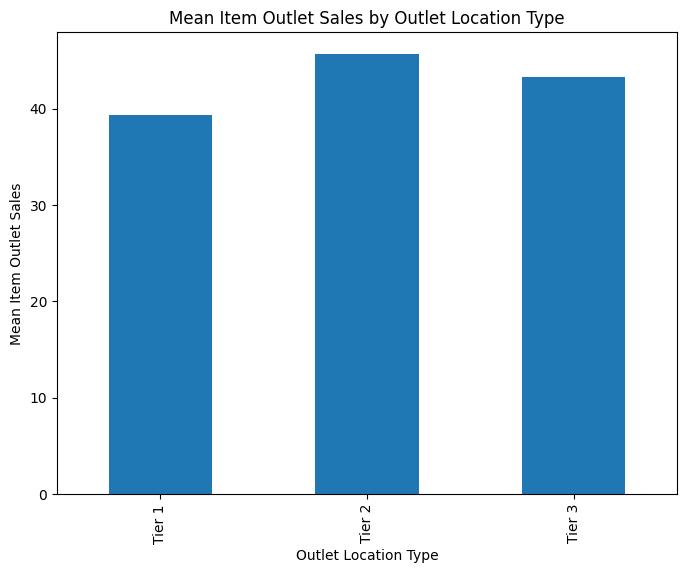

In [68]:

plt.figure(figsize=(8, 6))
df3.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.title('Mean Item Outlet Sales by Outlet Location Type')
plt.xlabel('Outlet Location Type')
plt.ylabel('Mean Item Outlet Sales')
plt.show()


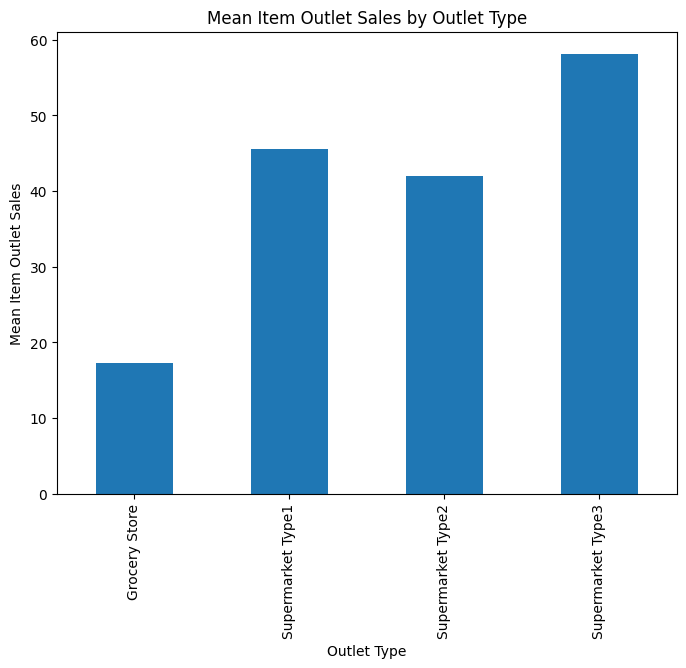

In [69]:

plt.figure(figsize=(8, 6))
df3.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.title('Mean Item Outlet Sales by Outlet Type')
plt.xlabel('Outlet Type')
plt.ylabel('Mean Item Outlet Sales')
plt.show()


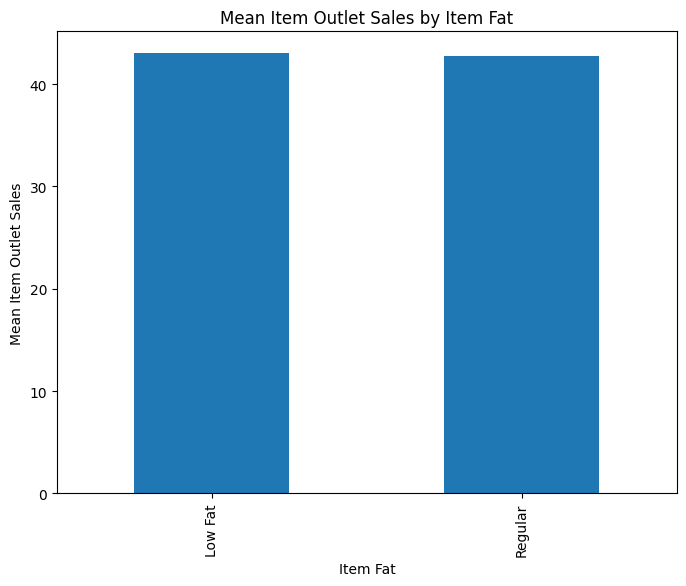

In [70]:


plt.figure(figsize=(8, 6))
df3.groupby('Item_Fat_Content')['Item_Outlet_Sales'].mean().plot(kind='bar')
plt.title('Mean Item Outlet Sales by Item Fat')
plt.xlabel('Item Fat')
plt.ylabel('Mean Item Outlet Sales')
plt.show()

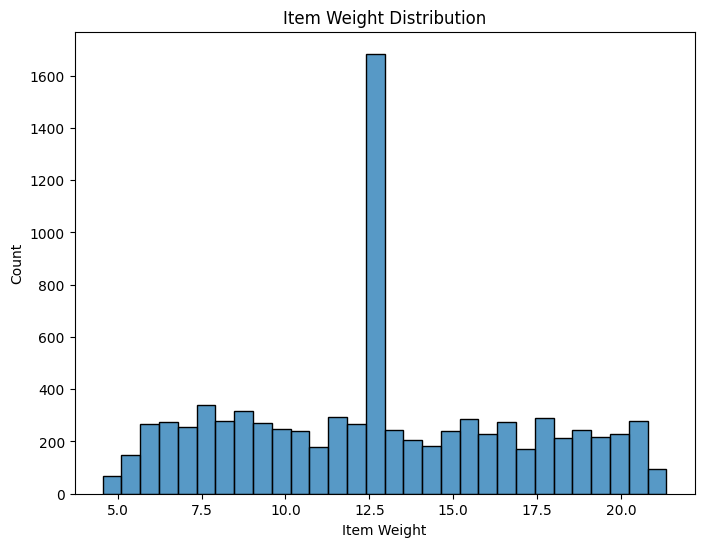

In [71]:
plt.figure(figsize=(8, 6))
sns.histplot(df3['Item_Weight'], bins=30)
plt.title('Item Weight Distribution')
plt.xlabel('Item Weight')
plt.ylabel('Count')
plt.show()

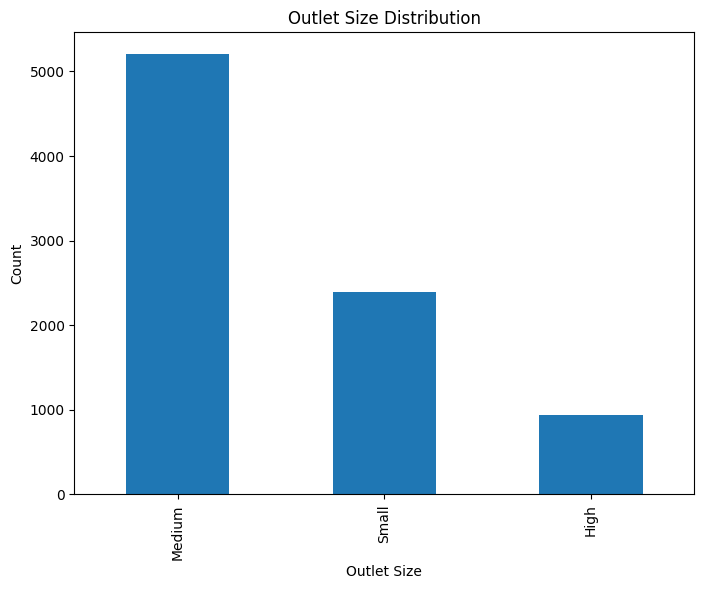

In [72]:
plt.figure(figsize=(8, 6))
df3['Outlet_Size'].value_counts().plot(kind='bar')
plt.title('Outlet Size Distribution')
plt.xlabel('Outlet Size')
plt.ylabel('Count')
plt.show()


## **Modeling**

### **Linear Regression**

In [73]:
X = df1.drop(['Item_Visibility', 'Item_Outlet_Sales'], axis=1)
y = df1['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 0.011685732065844485
R-squared (R2) Score: 0.5804071777926146


In [74]:
X = df1.drop(['Item_Visibility', 'Item_Outlet_Sales'], axis=1)
y = df1['Item_Outlet_Sales']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alpha = 0.1
model = Ridge(alpha=alpha)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)



Mean Squared Error (MSE): 0.011685740141548526
R-squared (R2) Score: 0.5804068878229807


### **RandomForest**

In [75]:
X = df1.drop([ 'Item_Outlet_Sales'], axis=1)
y = df1['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators = 100
model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 0.009596226142433197
R-squared (R2) Score: 0.6554338584047575


### **XGBoost**


In [76]:
X = df1.drop('Item_Outlet_Sales', axis=1)
y = df1['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.010162491731982725
R-squared (R2) Score: 0.6351012874114106
